In [3]:
# Used Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import json
import random
import time
import winsound 
import datetime

In [30]:
# Synthetic DATA: 
n_samples = 10000
np.random.seed(42)

# Generate normal data (50%)
heart_rate_normal = np.random.randint(60, 101, size=n_samples // 2)       # 60-100 bpm
oxygen_level_normal = np.random.randint(95, 101, size=n_samples // 2)     # 95-100%
temperature_normal = np.random.uniform(36.5, 37.5, size=n_samples // 2)   # 36.5-37.5 C

# Generate abnormal data (50%)
heart_rate_abnormal = np.concatenate((
    np.random.randint(40, 60, size=n_samples // 4),   # Low heart rate <60
    np.random.randint(101, 130, size=n_samples // 4)  # High heart rate >100
))
oxygen_level_abnormal = np.random.randint(80, 94, size=n_samples // 2)    # Low oxygen <95%
temperature_abnormal = np.concatenate((
    np.random.uniform(35, 36.4, size=n_samples // 4),  # Low temp <36.5
    np.random.uniform(38.1, 40, size=n_samples // 4)   # High temp >38
))

# Combine normal and abnormal data
heart_rate = np.concatenate((heart_rate_normal, heart_rate_abnormal))
oxygen_level = np.concatenate((oxygen_level_normal, oxygen_level_abnormal))
temperature = np.concatenate((temperature_normal, temperature_abnormal))

# Labels: 1 for normal, 0 for abnormal
status = np.array([1] * (n_samples // 2) + [0] * (n_samples // 2))

# Create timestamps spaced by 3 minutes starting from a fixed date
start_time = pd.Timestamp('2025-01-01 00:00:00')
timestamps = [start_time + pd.Timedelta(minutes=3 * i) for i in range(n_samples)]

# Create DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'heart_rate': heart_rate,
    'oxygen_level': oxygen_level,
    'temperature': temperature,
    'status': status
})

# Shuffle dataset rows 
df = df.sample(frac=1).reset_index(drop=True)

df.to_csv('synthetic_patient_data_with_time.csv', index=False)

print("Dataset with timestamps created, shape:", df.shape)
print(df.head())


Dataset with timestamps created, shape: (10000, 5)
            timestamp  heart_rate  oxygen_level  temperature  status
0 2025-01-20 02:33:00         125            82    38.997149       0
1 2025-01-06 14:03:00          69           100    37.161338       1
2 2025-01-03 00:45:00          95            95    37.292703       1
3 2025-01-01 10:48:00          66            95    37.371552       1
4 2025-01-04 05:03:00          88            96    37.492016       1


In [5]:
# Data pre-processing:
df = pd.read_csv('synthetic_patient_data_with_time.csv')
print(df.head())
print(df.info())
print(df['status'].value_counts())
#----------------------------------------------------------
max_heart_rate = df['heart_rate'].max()
print("Max heart rate:", max_heart_rate)

             timestamp  heart_rate  oxygen_level  temperature  status
0  2025-01-20 02:33:00         125            82    38.997149       0
1  2025-01-06 14:03:00          69           100    37.161338       1
2  2025-01-03 00:45:00          95            95    37.292703       1
3  2025-01-01 10:48:00          66            95    37.371552       1
4  2025-01-04 05:03:00          88            96    37.492016       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     10000 non-null  object 
 1   heart_rate    10000 non-null  int64  
 2   oxygen_level  10000 non-null  int64  
 3   temperature   10000 non-null  float64
 4   status        10000 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 390.8+ KB
None
status
0    5000
1    5000
Name: count, dtype: int64
Max heart rate: 129


C:\Users\clt\AppData\Local\Temp\ipykernel_23224\3346242878.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Abnormal (0)", "Normal (1)"])


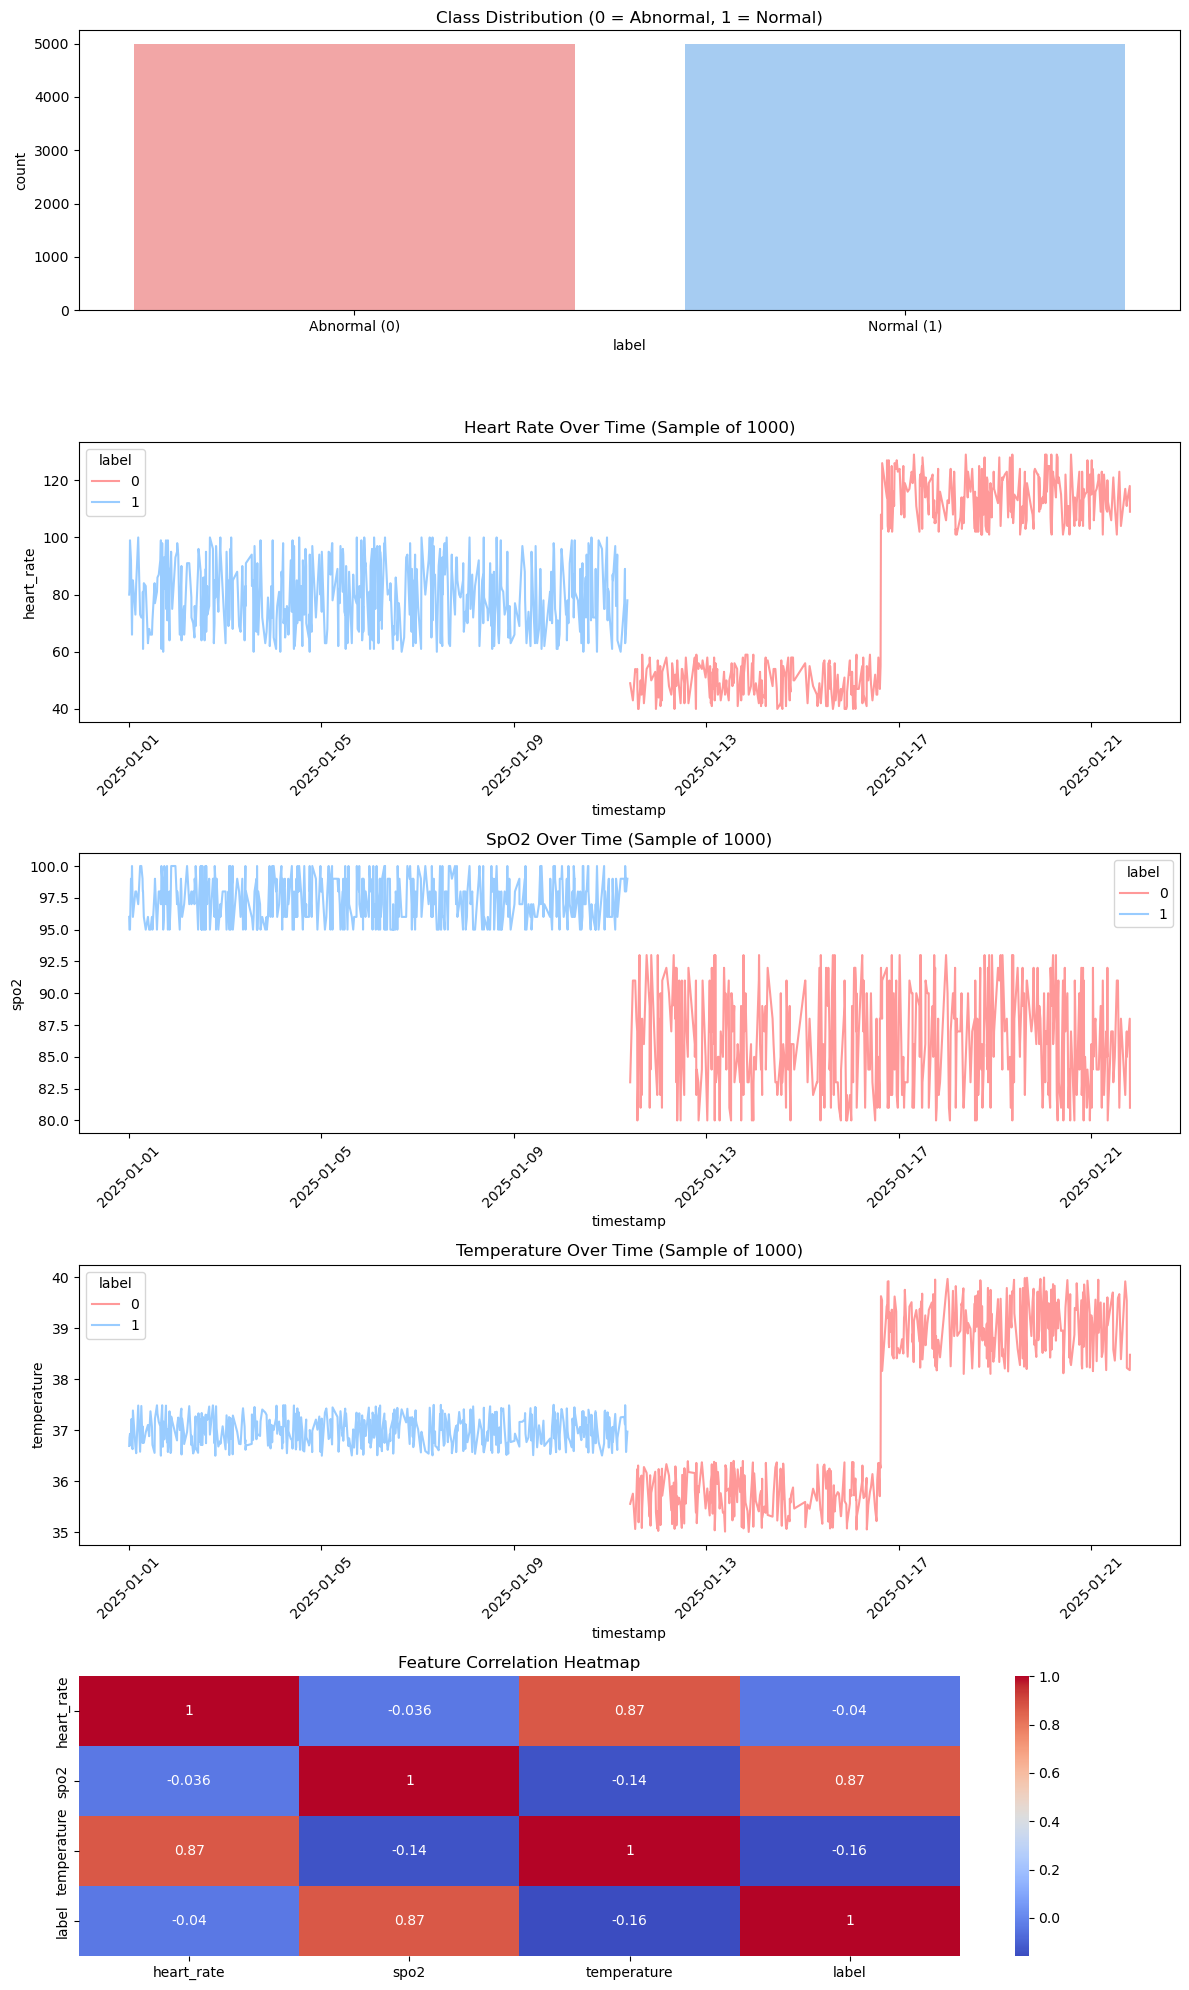

In [26]:
# Data Visualization :
df = pd.read_csv('synthetic_patient_data_with_time.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.rename(columns={'status': 'label', 'oxygen_level': 'spo2'}, inplace=True)

df['label'] = df['label'].astype(int)

palette = {0: "#FF9999", 1: "#99CCFF"}

fig, axs = plt.subplots(5, 1, figsize=(12, 20))

sns.countplot(x="label", hue="label", data=df, ax=axs[0], palette=palette, legend=False)
axs[0].set_title("Class Distribution (0 = Abnormal, 1 = Normal)")
axs[0].set_xticklabels(["Abnormal (0)", "Normal (1)"])

sns.lineplot(x="timestamp", y="heart_rate", hue="label", data=df.iloc[:1000], palette=palette, ax=axs[1])
axs[1].set_title("Heart Rate Over Time (Sample of 1000)")
axs[1].tick_params(axis='x', rotation=45)

sns.lineplot(x="timestamp", y="spo2", hue="label", data=df.iloc[:1000], palette=palette, ax=axs[2])
axs[2].set_title("SpO2 Over Time (Sample of 1000)")
axs[2].tick_params(axis='x', rotation=45)

sns.lineplot(x="timestamp", y="temperature", hue="label", data=df.iloc[:1000], palette=palette, ax=axs[3])
axs[3].set_title("Temperature Over Time (Sample of 1000)")
axs[3].tick_params(axis='x', rotation=45)

corr = df[["heart_rate", "spo2", "temperature", "label"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=axs[4])
axs[4].set_title("Feature Correlation Heatmap")

plt.tight_layout()
plt.show()


In [7]:
# Training and Evaluating the Logistic Regression model :

features = ['heart_rate', 'oxygen_level', 'temperature']
X = df[features]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 1.0
Confusion Matrix:
 [[1500    0]
 [   0 1500]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



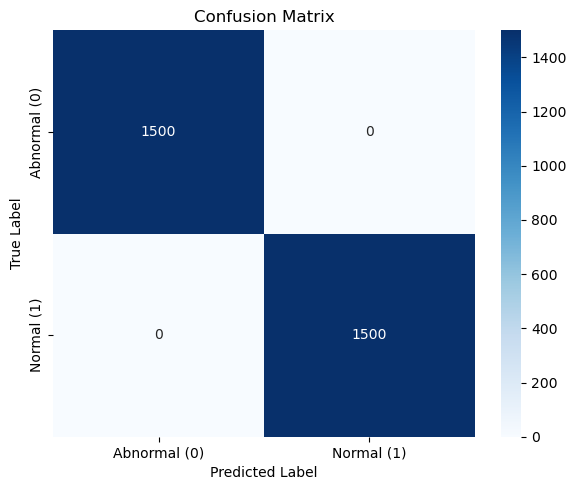

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm = np.array([[1500, 0], [0, 1500]])
labels = ['Abnormal (0)', 'Normal (1)']


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

plt.show()


In [34]:
# Save Model :
joblib.dump(model, 'logistic_regression_modelII.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!


In [5]:
# Tips :

detailed_tips = {
    "normal": "✅ All vitals are within normal range. Keep up the healthy habits!",
    "abnormal": {
        "heart_rate": {
            "low": "⚠️ Heart rate is too low (bradycardia). Sit or lie down and consult your doctor if you feel dizzy.",
            "high": "⚠️ Heart rate is too high (tachycardia). Try deep breathing or resting. If it persists, seek medical advice."
        },
        "oxygen_level": {
            "low": "⚠️ Oxygen level is low. Ensure you're in a well-ventilated area and take slow, deep breaths. Contact a doctor if it remains low.",
            "high": "⚠️ Oxygen level is high . Take a rest."
        },
        "temperature": {
            "low": "⚠️ Body temperature is unusually low. Cover yourself and drink warm fluids. Seek help if symptoms worsen.",
            "high": "⚠️ High temperature detected. Stay hydrated, rest, and monitor for fever symptoms. Consult a doctor if needed."
        }
    }
}

with open("tips.json", "w") as f:
    json.dump(detailed_tips, f, indent=4)


In [11]:
model = joblib.load("logistic_regression_modelII.joblib")

with open("tips.json") as f:
    tips = json.load(f)

thresholds = {
    "heart_rate": {"low": 60, "high": 100},
    "oxygen_level": {"low": 95 , "high" : 100}, 
    "temperature": {"low": 36.1, "high": 37.8}
}

def get_recommendation(input_data):
    features = np.array([[input_data["heart_rate"], input_data["oxygen_level"], input_data["temperature"]]])
    prediction = model.predict(features)[0]

    abnormal_tips = []

    if input_data["heart_rate"] < thresholds["heart_rate"]["low"]:
        abnormal_tips.append(tips["abnormal"]["heart_rate"]["low"])
    elif input_data["heart_rate"] > thresholds["heart_rate"]["high"]:
        abnormal_tips.append(tips["abnormal"]["heart_rate"]["high"])

    if input_data["oxygen_level"] < thresholds["oxygen_level"]["low"]:
        abnormal_tips.append(tips["abnormal"]["oxygen_level"]["low"])

    if input_data["temperature"] < thresholds["temperature"]["low"]:
        abnormal_tips.append(tips["abnormal"]["temperature"]["low"])
    elif input_data["temperature"] > thresholds["temperature"]["high"]:
        abnormal_tips.append(tips["abnormal"]["temperature"]["high"])

    if abnormal_tips:
        return "\n".join(abnormal_tips)
    else:
        return tips["normal"]




In [13]:
sample = {"heart_rate": 100, "oxygen_level": 98, "temperature": 37.5}
print(get_recommendation(sample))


✅ All vitals are within normal range. Keep up the healthy habits!


In [15]:
# Real-Time Simulation with sound alert for abnoraml status:
def play_alert():
    winsound.Beep(1000, 500)  

def simulate_real_time_monitoring_with_sound(model, scaler, n_cycles=5):
    for i in range(n_cycles):
        sample = {
            "heart_rate": random.randint(50, 150),
            "oxygen_level": round(random.uniform(80, 100), 1),
            "temperature": round(random.uniform(35.0, 41.0), 1)
        }

        X = pd.DataFrame([sample])

        X_scaled = scaler.transform(X)

        prediction = model.predict(X_scaled)[0]
        label = "Normal ✅" if prediction == 1 else "Abnormal ❌"

        if prediction == 0:
            play_alert()

        tip = get_recommendation(sample)

        print(f"\n📡 Reading {i+1}: {sample}")
        print(f"🧠 Prediction: {label}")
        print(f"💬 Tip: {tip}")
        
        time.sleep(7)

simulate_real_time_monitoring_with_sound(model, scaler, n_cycles=5)



📡 Reading 1: {'heart_rate': 76, 'oxygen_level': 84.8, 'temperature': 40.1}
🧠 Prediction: Abnormal ❌
💬 Tip: ⚠️ Oxygen level is low. Ensure you're in a well-ventilated area and take slow, deep breaths. Contact a doctor if it remains low.
⚠️ High temperature detected. Stay hydrated, rest, and monitor for fever symptoms. Consult a doctor if needed.

📡 Reading 2: {'heart_rate': 112, 'oxygen_level': 97.3, 'temperature': 39.8}
🧠 Prediction: Normal ✅
💬 Tip: ⚠️ Heart rate is too high (tachycardia). Try deep breathing or resting. If it persists, seek medical advice.
⚠️ High temperature detected. Stay hydrated, rest, and monitor for fever symptoms. Consult a doctor if needed.

📡 Reading 3: {'heart_rate': 74, 'oxygen_level': 93.2, 'temperature': 35.6}
🧠 Prediction: Abnormal ❌
💬 Tip: ⚠️ Oxygen level is low. Ensure you're in a well-ventilated area and take slow, deep breaths. Contact a doctor if it remains low.
⚠️ Body temperature is unusually low. Cover yourself and drink warm fluids. Seek help if

In [23]:
model = joblib.load("logistic_regression_modelII.joblib")
scaler = joblib.load("scaler.joblib")
with open("tips.json", "r") as f:
    tips_data = json.load(f)

def simulate_api_input(reading):
    features = np.array([[reading["heart_rate"], reading["oxygen_level"], reading["temperature"]]])
    scaled_features = scaler.transform(features)
    
    prediction = model.predict(scaled_features)[0]
    
    rec_tips = []
    if prediction == 0:  
        if reading["heart_rate"] < 60:
            rec_tips.append(tips_data["abnormal"]["heart_rate"]["low"])
        elif reading["heart_rate"] > 100:
            rec_tips.append(tips_data["abnormal"]["heart_rate"]["high"])
        
        if reading["oxygen_level"] < 92:
            rec_tips.append(tips_data["abnormal"]["oxygen_level"]["low"])
        elif reading["oxygen_level"] > 100:
            rec_tips.append(tips_data["abnormal"]["oxygen_level"]["high"])
        
        if reading["temperature"] < 36.1:
            rec_tips.append(tips_data["abnormal"]["temperature"]["low"])
        elif reading["temperature"] > 37.5:
            rec_tips.append(tips_data["abnormal"]["temperature"]["high"])
    else:
        rec_tips.append(tips_data["normal"])
    
    result = {
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "input": reading,
        "prediction": "Normal" if prediction == 1 else "Abnormal",
        "tips": rec_tips
    }
    
    return result

# Simulate input
sample_readings = [
    {"heart_rate": 98, "oxygen_level": 98, "temperature": 37.2},
    {"heart_rate": 60, "oxygen_level": 89, "temperature": 36.2},
    {"heart_rate": 90, "oxygen_level": 97, "temperature": 37.7}
]

outputs = [simulate_api_input(reading) for reading in sample_readings]

for out in outputs:
    print("📊 New Reading:", out["input"])
    print("✅ Prediction:", out["prediction"])
    print("💬 Recommendation:", *out["tips"], "\n")


📊 New Reading: {'heart_rate': 98, 'oxygen_level': 98, 'temperature': 37.2}
✅ Prediction: Normal
💬 Recommendation: ✅ All vitals are within normal range. Keep up the healthy habits! 

📊 New Reading: {'heart_rate': 60, 'oxygen_level': 89, 'temperature': 36.2}
✅ Prediction: Abnormal
💬 Recommendation: ⚠️ Oxygen level is low. Ensure you're in a well-ventilated area and take slow, deep breaths. Contact a doctor if it remains low. 

📊 New Reading: {'heart_rate': 90, 'oxygen_level': 97, 'temperature': 37.7}
✅ Prediction: Normal
💬 Recommendation: ✅ All vitals are within normal range. Keep up the healthy habits! 



D:\Anaconda\App\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\App\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Anaconda\App\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# MQTT :

